# Reproducing SkimLit Project:  Sequential Sentence Classification in Medical Abstracts

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt

import random
import os

## Preprocessing data

In [2]:
# Path with data
data_path = 'D:/Python/Проекты/SkimLit/PubMed_20k//'

In [3]:
# Files in directory
os.listdir(data_path)

['dev.txt', 'test.txt', 'train.txt']

In [4]:
def get_lines(path, file):
    '''
    Create list with strings from file
    
    Parameters:
    ----------
    path : str, path of data directory
    file : str, name of the file
    '''
    
    with open(path + file, 'r') as f:
        return f.readlines()

In [5]:
train_data = get_lines(data_path, 'train.txt')
val_data = get_lines(data_path, 'dev.txt')
test_data = get_lines(data_path, 'test.txt')

In [6]:
train_data[0:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [7]:
def get_dict_from_file(data):
    '''
    Create list with dicts from list with strings
    
    Parematers:
    ----------
    data: list with strings
    '''
    
    abstract_sentences = []
    abstract_id = ''
    list_of_dicts = []
    for line in data:
        if line.startswith('###'):
            abstract_id = line
            abstract_sentences = []
        elif line.isspace():
            for number, sentence in enumerate(abstract_sentences):
                dict_of_sentence = {}
                dict_of_sentence['id'] = abstract_id.lstrip('###').rstrip()
                dict_of_sentence['category'] = sentence.split('\t')[0]
                dict_of_sentence['text'] = sentence.split('\t')[1].strip()
                dict_of_sentence['number_of_string'] = number + 1
                dict_of_sentence['total_lines'] = len(abstract_sentences)
                
                list_of_dicts.append(dict_of_sentence)
        else:
            abstract_sentences.append(line)
            
    return list_of_dicts

In [8]:
get_dict_from_file(train_data)[0:5]

[{'id': '24293578',
  'category': 'OBJECTIVE',
  'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
  'number_of_string': 1,
  'total_lines': 12},
 {'id': '24293578',
  'category': 'METHODS',
  'text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'number_of_string': 2,
  'total_lines': 12},
 {'id': '24293578',
  'category': 'METHODS',
  'text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'number_of_string': 3,
  'total_lines': 12},
 {'id': '24293578',
  'category': 'METHODS',
  'text': 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'number_of_string': 4,
  

In [9]:
# Creating DataFrames
train_df = pd.DataFrame(get_dict_from_file(train_data))
val_df = pd.DataFrame(get_dict_from_file(val_data))
test_df = pd.DataFrame(get_dict_from_file(test_data))

In [10]:
train_df.head()

,id,category,text,number_of_string,total_lines
0,24293578,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,1,12
1,24293578,METHODS,A total of @ patients with primary knee OA wer...,2,12
2,24293578,METHODS,Outcome measures included pain reduction and i...,3,12
3,24293578,METHODS,Pain was assessed using the visual analog pain...,4,12
4,24293578,METHODS,Secondary outcome measures included the Wester...,5,12


In [11]:
# Add engineering feature - number/total lines ratio
train_df['number_lines_ratio'] = train_df.number_of_string / train_df.total_lines

In [12]:
# Converting 
train_df['category'] = train_df['category'].astype('category')
val_df['category'] = val_df['category'].astype('category')
test_df['category'] = test_df['category'].astype('category')

In [13]:
train_df.head()

,id,category,text,number_of_string,total_lines,number_lines_ratio
0,24293578,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,1,12,0.083333
1,24293578,METHODS,A total of @ patients with primary knee OA wer...,2,12,0.166667
2,24293578,METHODS,Outcome measures included pain reduction and i...,3,12,0.250000
3,24293578,METHODS,Pain was assessed using the visual analog pain...,4,12,0.333333
4,24293578,METHODS,Secondary outcome measures included the Wester...,5,12,0.416667


## Exploratory analysis

#### Number of sentences per label

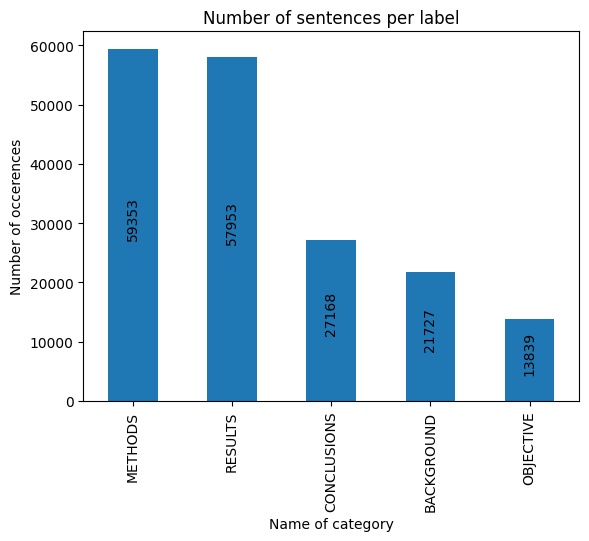

In [14]:
number_of_categories = train_df.category.value_counts()

ax = number_of_categories.plot(kind='bar',
                               title='Number of sentences per label',
                               xlabel='Name of category',
                               ylabel='Number of occerences')

ax.bar_label(ax.containers[0], label_type='center', rotation=90, padding=5)
ax.margins(y=0.05)

### Number of tokens per sentence

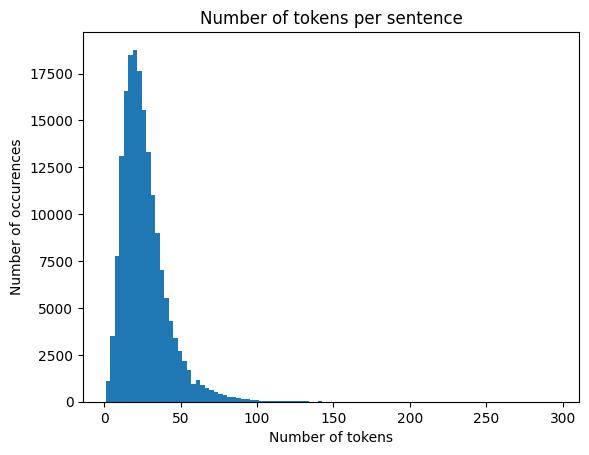

In [15]:
sentences = train_df.text.to_numpy()
tokens_counts = [len(sentence.split()) for sentence in sentences]

plt.hist(tokens_counts, bins=100)

plt.title('Number of tokens per sentence')
plt.xlabel('Number of tokens')
plt.ylabel('Number of occurences');

In [16]:
# 95th percentile of the tokens_counts
tokens_counts_95_perc = int(np.percentile(tokens_counts, 95))
print(f'95th percentile of tokens counts is {tokens_counts_95_perc}')

95th percentile of tokens counts is 55


### Number of total lines per abctract

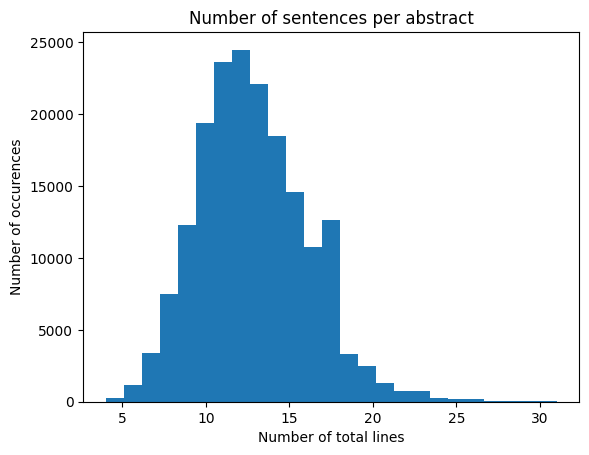

In [17]:
total_lines = train_df.total_lines

plt.hist(total_lines, bins=25)

plt.title('Number of sentences per abstract')
plt.xlabel('Number of total lines')
plt.ylabel('Number of occurences');

In [18]:
# 95th percentile of the total_lines
total_lines_95_perc = np.percentile(total_lines, 95)
print(f'95th percentile of total_lines is {total_lines_95_perc}')

95th percentile of total_lines is 19.0


## Make numeric labels

In [19]:
num_classes = len(train_df.category.cat.categories)
print(f'Number of classes is {num_classes}')

Number of classes is 5


In [20]:
train_df.category

0           OBJECTIVE
1             METHODS
2             METHODS
3             METHODS
4             METHODS
             ...     
180035        RESULTS
180036        RESULTS
180037        RESULTS
180038    CONCLUSIONS
180039    CONCLUSIONS
Name: category, Length: 180040, dtype: category
Categories (5, object): ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']

In [21]:
labels_train = train_df.category.cat.codes.to_numpy()
labels_val = val_df.category.cat.codes.to_numpy()
labels_test = test_df.category.cat.codes.to_numpy()

In [22]:
labels_train_one_hot = tf.one_hot(labels_train, num_classes)
labels_val_one_hot = tf.one_hot(labels_val, num_classes)
labels_test_one_hot = tf.one_hot(labels_test, num_classes)

In [23]:
labels_train_one_hot

<tf.Tensor: shape=(180040, 5), dtype=float32, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)>

## Converting text data to numerical vectors

In [24]:
train_sentences = train_df.text.to_list()
val_sentences = val_df.text.to_list()
test_sentences = test_df.text.to_list()

### Token converting

#### Token vectorization

In [25]:
all_tokens = [word for sentence in train_sentences for word in sentence.split()]
print(f'Number of words in train sentences is {len(all_tokens)}')
print(f'Number of different words in train sentences is {len(set(all_tokens))}')

Number of words in train sentences is 4741942
Number of different words in train sentences is 83102


In [26]:
MAX_TOKENS = 68000 # like in the paper
OUTPUT_TOKEN_LENGTH = tokens_counts_95_perc

In [27]:
# from tensorflow.keras.layers import TextVectorization

# token_vectorizer = TextVectorization(max_tokens=MAX_TOKENS,
#                                      output_sequence_length=OUTPUT_TOKEN_LENGTH,
#                                      name='token_vectorizer')

# token_vectorizer.adapt(train_sentences)

In [28]:
# target_sentence = random.choice(train_sentences)
# print(f"Text:\n{target_sentence}")
# print(f"\nLength of text: {len(target_sentence.split())}")
# print(f"\nVectorized text:\n{token_vectorizer([target_sentence])}")

In [29]:
# text_vocab = token_vectorizer.get_vocabulary()
# print(f"Number of words in vocabulary: {len(text_vocab)}"), 
# print(f"Most common words in the vocabulary: {text_vocab[:5]}")
# print(f"Least common words in the vocabulary: {text_vocab[-5:]}")

#### Token embedding

In [30]:
# from tensorflow.keras.layers import Embedding

# token_embedder = Embedding(input_dim=len(text_vocab),
#                            output_dim=128,
#                            mask_zero=True,
#                            name='token_embedding')

In [31]:
# print(f"Sentence before vectorization:\n{target_sentence}\n")
# vectorized_sentence = token_vectorizer([target_sentence])
# print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
# embedded_sentence = token_embedder(vectorized_sentence)
# print(f"Sentence after embedding:\n{embedded_sentence}\n")
# print(f"Embedded sentence shape: {embedded_sentence.shape}")

### Char converting

In [32]:
def split_chars(text):
    '''
    Splits char to string
    
    Parameters:
    ----------
    text : str, text
    '''
    return " ".join(list(text))

In [33]:
target_sentence = random.choice(train_sentences)
split_chars(target_sentence)

'T h i s   s t u d y   i n v o l v e s   a   r a n d o m i s e d   c o n t r o l l e d   t r i a l   o f   a   T R P - r i c h   e g g - w h i t e   p r o t e i n   h y d r o l y s a t e   (   D S M   N u t r i t i o n a l   P r o d u c t s   L t d .   ,   S w i t z e r l a n d   )   o n   p l a s m a   a m i n o   a c i d s   ,   c o g n i t i o n   ,   m o o d   a n d   e m o t i o n a l   p r o c e s s i n g   i n   o l d e r   w o m e n   .'

In [34]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

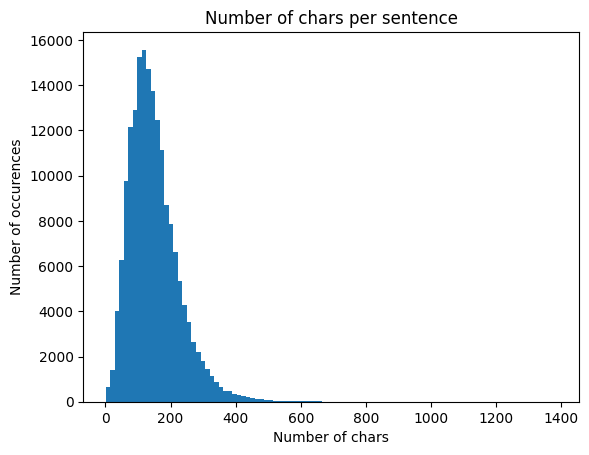

In [35]:
char_lens = [len(sentence) for sentence in train_sentences]

plt.hist(char_lens, bins=100)

plt.title('Number of chars per sentence')
plt.xlabel('Number of chars')
plt.ylabel('Number of occurences');

In [36]:
# 95th percentile of the char_lens
chars_counts_95_perc = int(np.percentile(char_lens, 95))
print(f'95th percentile of tokens counts is {chars_counts_95_perc}')

95th percentile of tokens counts is 290


In [37]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [38]:
MAX_CHAR = len(alphabet)
OUTPUT_CHAR_LENGTH = chars_counts_95_perc

#### Char vectorization

In [39]:
from tensorflow.keras.layers import TextVectorization

char_vectorizer = TextVectorization(max_tokens=MAX_CHAR,
                                    output_sequence_length=OUTPUT_CHAR_LENGTH,
                                    name='char_vectorizer')

char_vectorizer.adapt(train_chars)

In [40]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [41]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
T h e   t e s t   p e r f o r m a n c e   c r i t e r i a   a r e   c o m p a r a b l e   t o   t h a t   o f   m S T a R T   ,   w h e r e a s   A S A V   t r i a g e   m i g h t   b e   a c c o m p l i s h e d   s l i g h t l y   f a s t e r   .

Length of chars: 105

Vectorized chars:
[[ 3 13  2  3  2  9  3 14  2  8 17  7  8 15  5  6 11  2 11  8  4  3  2  8
   4  5  5  8  2 11  7 15 14  5  8  5 22 12  2  3  7  3 13  5  3  7 17 15
   9  3  5  8  3 20 13  2  8  2  5  9  5  9  5 21  3  8  4  5 18  2 15  4
  18 13  3 22  2  5 11 11  7 15 14 12  4  9 13  2 10  9 12  4 18 13  3 12
  19 17  5  9  3  2  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0 

#### Char embedding

In [42]:
from tensorflow.keras.layers import Embedding

char_embedder = Embedding(input_dim=len(char_vocab),
                          output_dim=25,
                          mask_zero=False,
                          name='char_embedding')

In [43]:
# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embedder(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
T h e   t e s t   p e r f o r m a n c e   c r i t e r i a   a r e   c o m p a r a b l e   t o   t h a t   o f   m S T a R T   ,   w h e r e a s   A S A V   t r i a g e   m i g h t   b e   a c c o m p l i s h e d   s l i g h t l y   f a s t e r   .

Embedded chars (after vectorization and embedding):
[[[ 0.04260639  0.00227896 -0.01175117 ...  0.00384011 -0.04711629
    0.04462322]
  [ 0.00292844 -0.0030968  -0.00979733 ...  0.04781885  0.04492703
    0.04341194]
  [-0.01318407  0.03230515  0.03707376 ...  0.02748132  0.02478666
    0.04760852]
  ...
  [ 0.04168298 -0.00015544 -0.04834392 ... -0.00861568  0.03103404
    0.00407317]
  [ 0.04168298 -0.00015544 -0.04834392 ... -0.00861568  0.03103404
    0.00407317]
  [ 0.04168298 -0.00015544 -0.04834392 ... -0.00861568  0.03103404
    0.00407317]]]

Character embedding shape: (1, 290, 25)


### Creating universal sentence encoder layer

In [44]:
with tf.device('/CPU:0'):
    tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

## Preparing other inputs (number_of_string, total_lines)

### Number of string

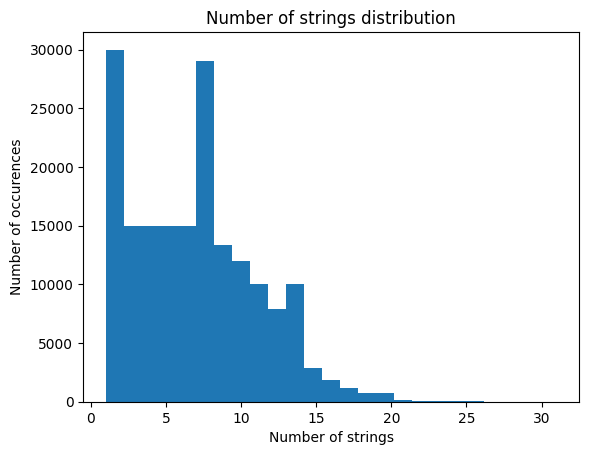

In [45]:
numbers_of_strings = train_df.number_of_string.to_numpy()

plt.hist(numbers_of_strings, bins=25)

plt.title('Number of strings distribution')
plt.xlabel('Number of strings')
plt.ylabel('Number of occurences');

In [46]:
number_of_strings_counts_95_perc = int(np.percentile(numbers_of_strings, 95))
print(f'95th percentile of tokens counts is {number_of_strings_counts_95_perc}')

95th percentile of tokens counts is 14


In [47]:
train_strings_numbers_one_hot = tf.one_hot(train_df.number_of_string.to_numpy(), depth=number_of_strings_counts_95_perc)
val_strings_numbers_one_hot = tf.one_hot(val_df.number_of_string.to_numpy(), depth=number_of_strings_counts_95_perc)
test_strings_numbers_one_hot = tf.one_hot(test_df.number_of_string.to_numpy(), depth=number_of_strings_counts_95_perc)

### Total lines

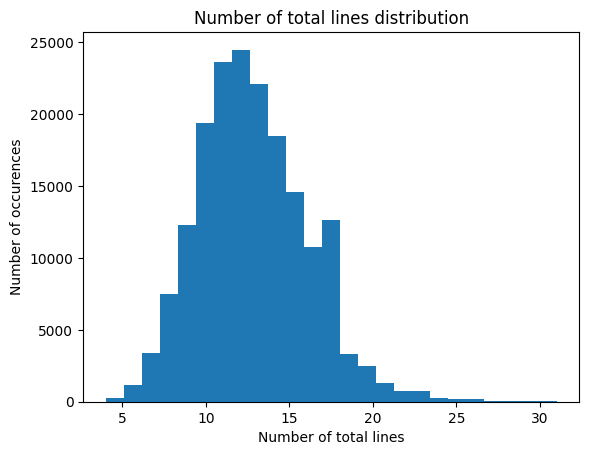

In [48]:
numbers_of_total_lines = train_df.total_lines.to_numpy()

plt.hist(numbers_of_total_lines, bins=25)

plt.title('Number of total lines distribution')
plt.xlabel('Number of total lines')
plt.ylabel('Number of occurences');

In [49]:
number_of_total_lines_counts_95_perc = int(np.percentile(numbers_of_total_lines, 95))
print(f'95th percentile of tokens counts is {number_of_total_lines_counts_95_perc}')

95th percentile of tokens counts is 19


In [50]:
train_total_lines_numbers_one_hot = tf.one_hot(train_df.total_lines.to_numpy(), depth=number_of_total_lines_counts_95_perc)
val_total_lines_numbers_one_hot = tf.one_hot(val_df.total_lines.to_numpy(), depth=number_of_total_lines_counts_95_perc)
test_total_lines_numbers_one_hot = tf.one_hot(test_df.total_lines.to_numpy(), depth=number_of_total_lines_counts_95_perc)

## Creating Datasets

In [51]:
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_strings_numbers_one_hot, # line numbers
                                                                train_total_lines_numbers_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars

train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(labels_train_one_hot)
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels))
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_strings_numbers_one_hot, # line numbers
                                                              val_total_lines_numbers_one_hot, # total lines
                                                              val_sentences, # train tokens
                                                              val_chars)) # train chars

val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(labels_val_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_strings_numbers_one_hot, # line numbers
                                                               test_total_lines_numbers_one_hot, # total lines
                                                               test_sentences, # train tokens
                                                               test_chars)) # train chars

test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(labels_test_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## Building Model

In [52]:
from tensorflow.keras import layers

In [53]:
with tf.device('/CPU:0'):
    # 1. Token inputs
    token_inputs = layers.Input(shape=[], dtype='string', name='token_inputs')
    univ_sent_embeddings = tf_hub_embedding_layer(token_inputs)
    token_outputs = layers.Dense(128, activation='relu')(univ_sent_embeddings)
    token_model = tf.keras.Model(inputs=token_inputs, outputs=token_outputs)

    # 2. Char inputs
    char_inputs = layers.Input(shape=(1,), dtype='string', name='char_inputs')
    char_vectors = char_vectorizer(char_inputs)
    char_embeddings = char_embedder(char_vectors)
    char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
    char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

    # 3. Line number inputs
    line_number_inputs = layers.Input(shape=(14,), dtype=tf.int32, name='line_number_inputs')
    x = layers.Dense(32, activation='relu')(line_number_inputs)
    line_number_model = tf.keras.Model(inputs=line_number_inputs, outputs=x)

    # 4. Total lines inputs
    total_lines_inputs = layers.Input(shape=(19,), dtype=tf.int32, name='total_lines_inputs')
    y = layers.Dense(32, activation='relu')(total_lines_inputs)
    total_lines_model = tf.keras.Model(inputs=total_lines_inputs, outputs=y)

    # 5. Combined token and char embeddings
    token_char_conc_embeddings = layers.Concatenate(name='token_char_conc_embeddings')([token_model.output, char_model.output])

    z = layers.Dense(256, activation='relu')(token_char_conc_embeddings)
    z = layers.Dropout(0.5)(z)

    # 6. Combine token_char_conc_embeddings with positional embeddings
    z = layers.Concatenate(name='token_char_positional_embedding')([line_number_model.output,
                                                                    total_lines_model.output,
                                                                    z])
    # 7. Create output layer
    output_layer = layers.Dense(5, activation='softmax', name='output_layer')(z)

    # 8. Put together model
    model = tf.keras.Model(inputs=[line_number_model.input,
                                   total_lines_model.input,
                                   token_model.input,
                                   char_model.input],
                            outputs=output_layer)

In [54]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     

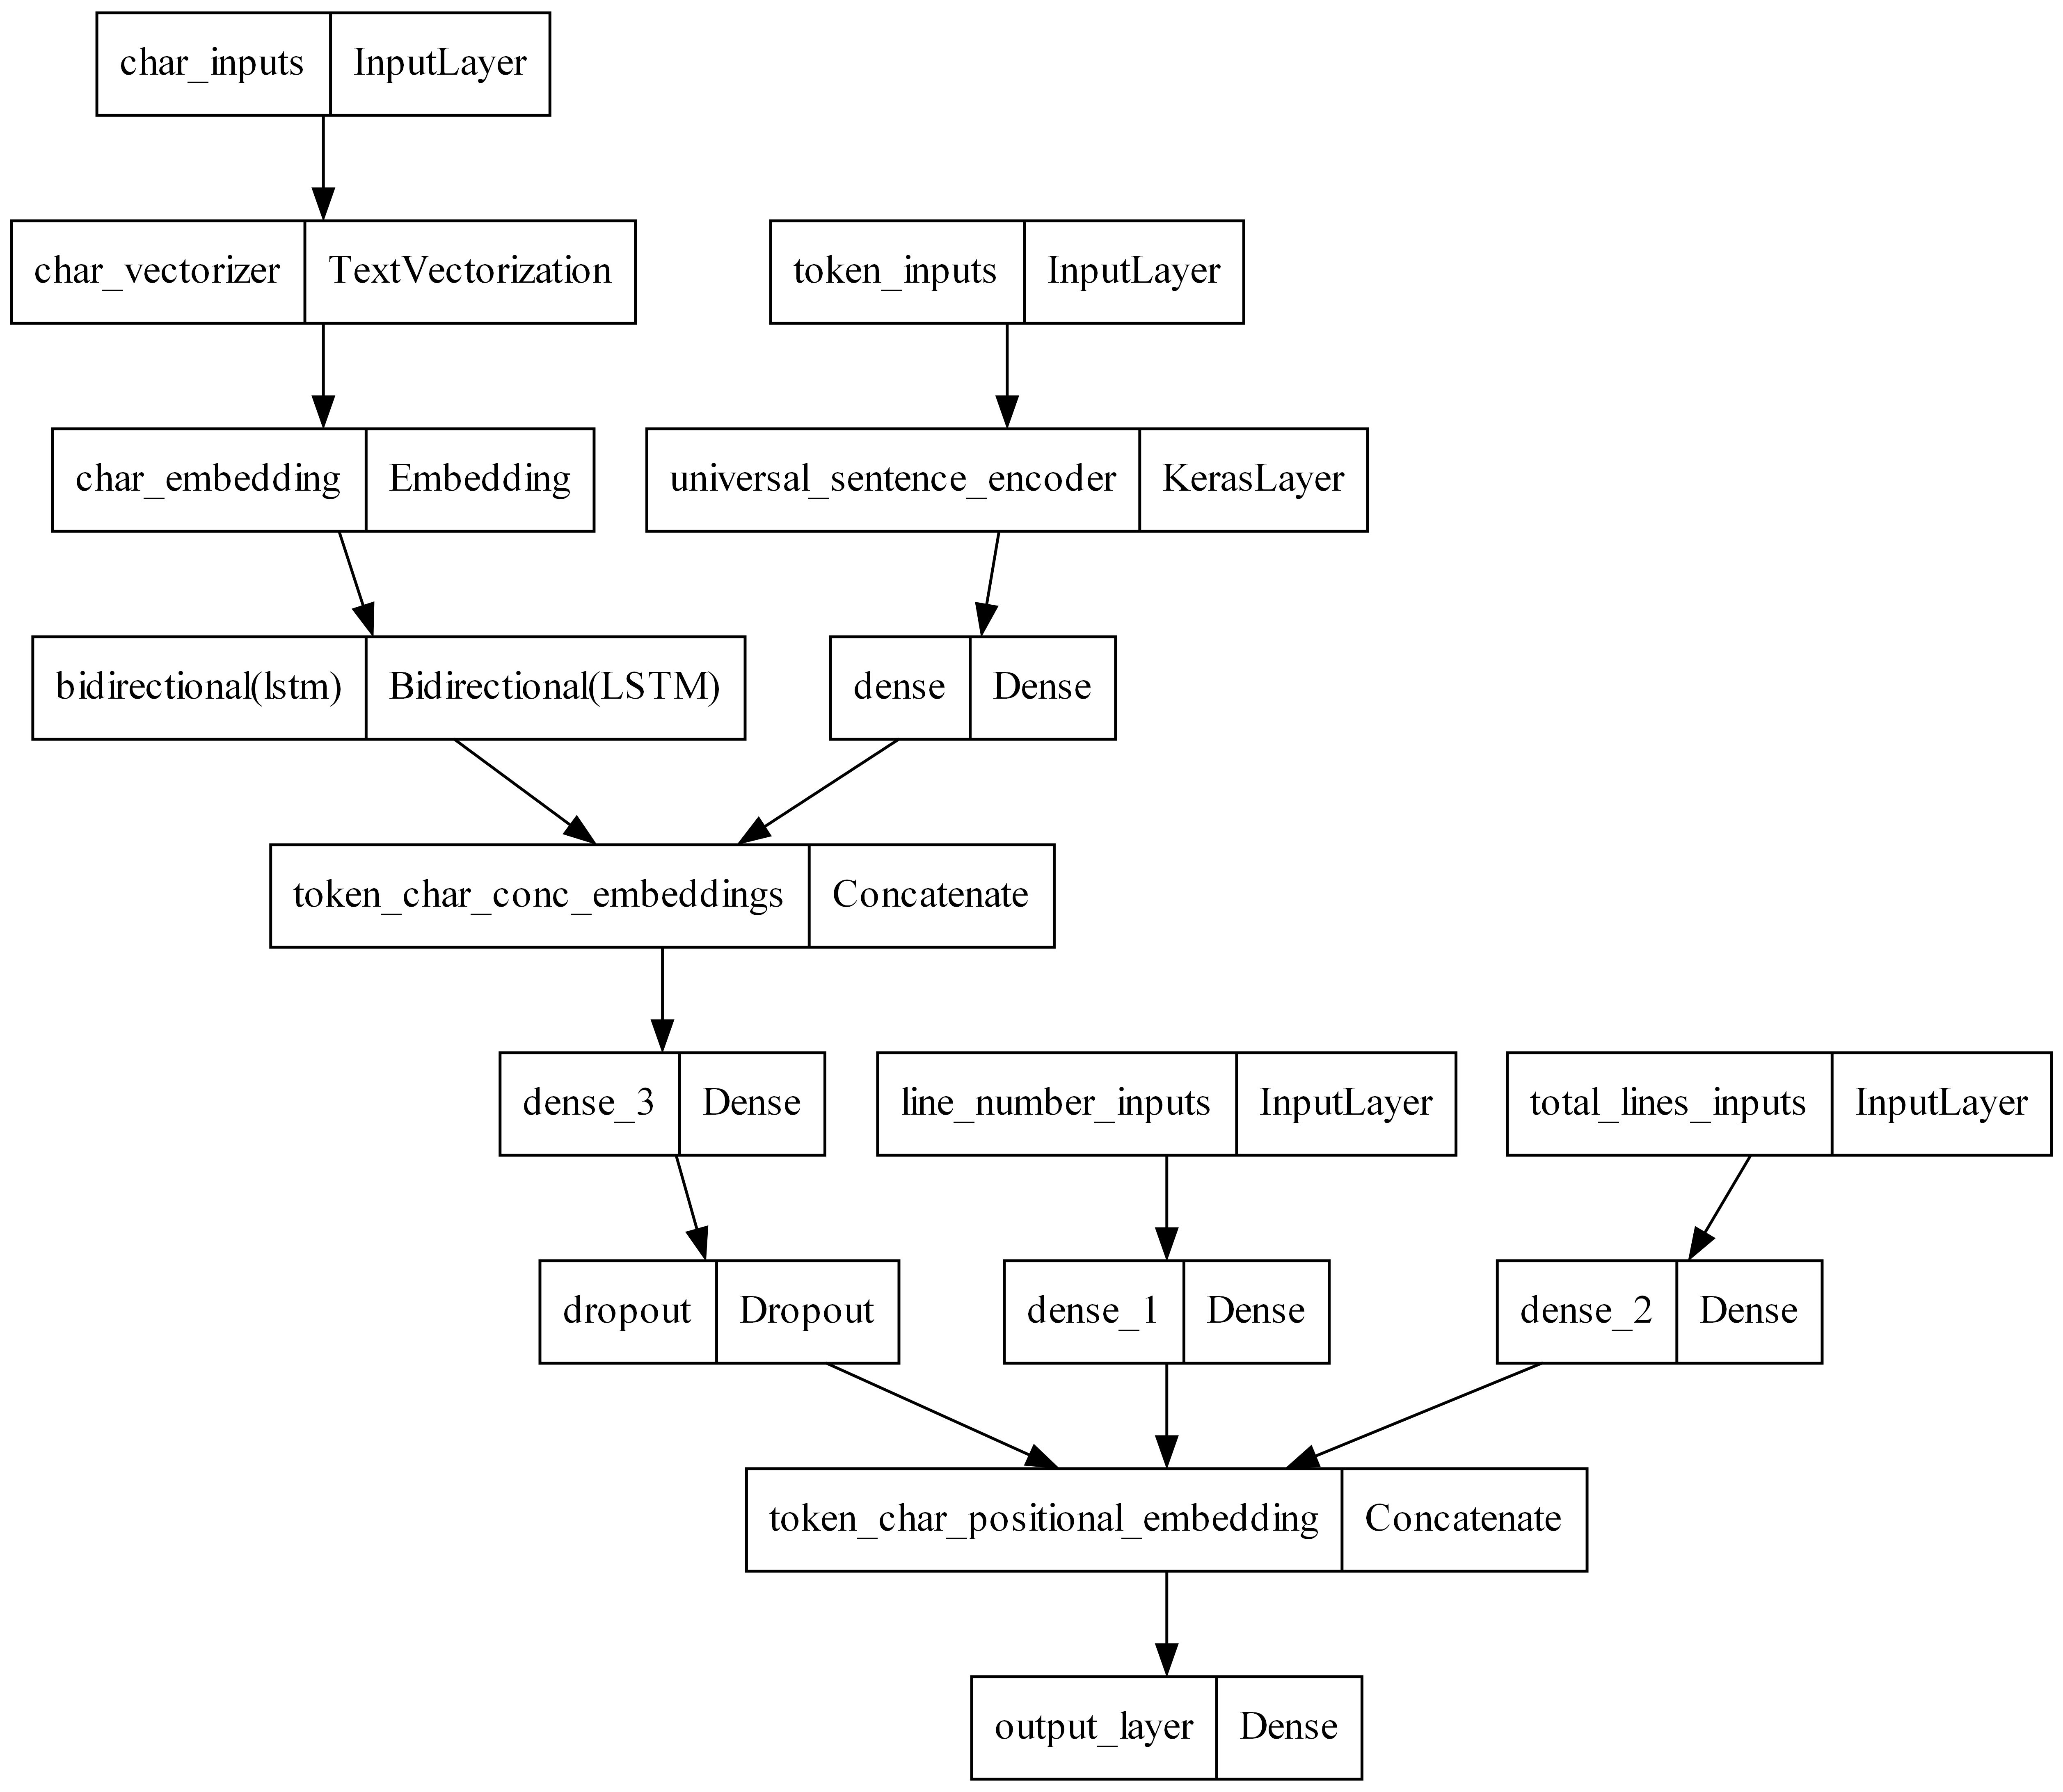

In [55]:
from tensorflow.keras.utils import plot_model
plot_model(model, dpi=500)

In [56]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
             metrics=['accuracy'])

In [57]:
with tf.device('/cpu:0'):
    history_of_model = model.fit(train_pos_char_token_dataset,
                                 epochs=10,
                                 steps_per_epoch=int(len(train_pos_char_token_dataset)),
                                 validation_data=val_pos_char_token_dataset,
                                 validation_steps=int(0.1*len(val_pos_char_token_dataset)))

Epoch 1/10
5627/5627 [==============================] - 1415s 247ms/step - loss: 0.9543 - accuracy: 0.8220 - val_loss: 0.9153 - val_accuracy: 0.8438
Epoch 2/10
5627/5627 [==============================] - 1294s 230ms/step - loss: 0.9101 - accuracy: 0.8531 - val_loss: 0.9058 - val_accuracy: 0.8551
Epoch 3/10
5627/5627 [==============================] - 1122s 199ms/step - loss: 0.8978 - accuracy: 0.8615 - val_loss: 0.9004 - val_accuracy: 0.8554
Epoch 4/10
5627/5627 [==============================] - 1031s 183ms/step - loss: 0.8896 - accuracy: 0.8680 - val_loss: 0.9003 - val_accuracy: 0.8517
Epoch 5/10
5627/5627 [==============================] - 1069s 190ms/step - loss: 0.8832 - accuracy: 0.8730 - val_loss: 0.8997 - val_accuracy: 0.8554
Epoch 6/10
5627/5627 [==============================] - 1232s 219ms/step - loss: 0.8774 - accuracy: 0.8776 - val_loss: 0.9000 - val_accuracy: 0.8561
Epoch 7/10
5627/5627 [==============================] - 1312s 233ms/step - loss: 0.8726 - accuracy: 0.8815

In [58]:
def plot_history(history):
    
    '''
    Plots history of model
    
    Args:
        history: tf.keras.callbacks.History that records events into a History object
    '''
    
    df = pd.DataFrame(history.history)
    df[['loss', 'val_loss']].plot(title='Loss plot', xlabel='Epochs', ylabel='Loss')
    
    df[['accuracy', 'val_accuracy']].plot(title='Accuracy plot', xlabel='Epochs', ylabel='Accuracy')

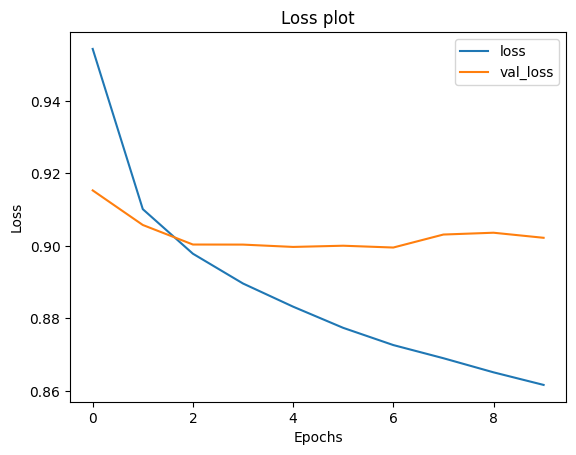

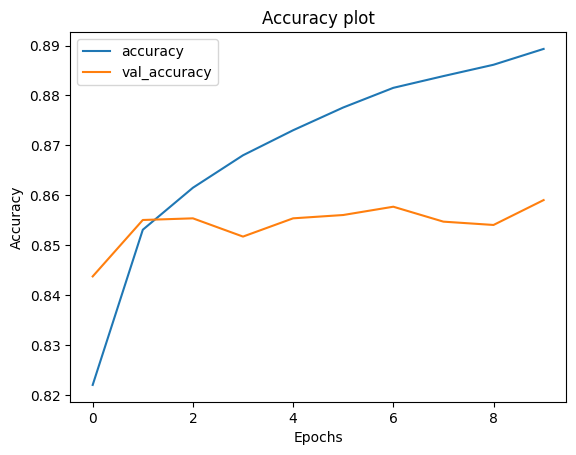

In [59]:
plot_history(history_of_model)

## Evaluating model on validation dataset

In [60]:
with tf.device('/cpu:0'):
    model_pred_probs_val = model.predict(val_pos_char_token_dataset, verbose=1)
    model_preds_val = tf.argmax(model_pred_probs_val, axis=1)

945/945 [==============================] - 64s 65ms/step


In [61]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print(f'Accuracy score is {round(accuracy_score(labels_val, model_preds_val), 3)}')
print(f'Precision score is {round(precision_score(labels_val, model_preds_val, average="weighted", zero_division=0), 3)}')
print(f'Recall score is {round(recall_score(labels_val, model_preds_val, average="weighted"), 3)}')
print(f'F1-score is {round(f1_score(labels_val, model_preds_val, average="weighted"), 3)}')

Accuracy score is 0.852
Precision score is 0.852
Recall score is 0.852
F1-score is 0.849


## Saving and loading model

In [62]:
model.save('skimlit_model')

INFO:tensorflow:Assets written to: skimlit_model\assets


INFO:tensorflow:Assets written to: skimlit_model\assets


In [63]:
loaded_model = tf.keras.models.load_model('skimlit_model')

## Evaluating model on Test dataset

In [64]:
with tf.device('/cpu:0'):
    model_pred_probs_test = loaded_model.predict(test_pos_char_token_dataset, verbose=1)
    model_preds_test = tf.argmax(model_pred_probs_test, axis=1)

942/942 [==============================] - 102s 90ms/step


In [65]:
print(f'Accuracy score is {round(accuracy_score(labels_test, model_preds_test), 3)}')
print(f'Precision score is {round(precision_score(labels_test, model_preds_test, average="weighted", zero_division=0), 3)}')
print(f'Recall score is {round(recall_score(labels_test, model_preds_test, average="weighted"), 3)}')
print(f'F1-score is {round(f1_score(labels_test, model_preds_test, average="weighted"), 3)}')

Accuracy score is 0.849
Precision score is 0.849
Recall score is 0.849
F1-score is 0.846


### Building confusion matrix

In [66]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matr = confusion_matrix(labels_test, model_preds_test)
conf_matr

array([[2971,   59,  257,  300,   34],
       [  30, 3907,   41,    0,  593],
       [ 106,   87, 8864,   32,  808],
       [ 925,    2,  152, 1239,   15],
       [  18,  413,  689,    0, 8593]], dtype=int64)

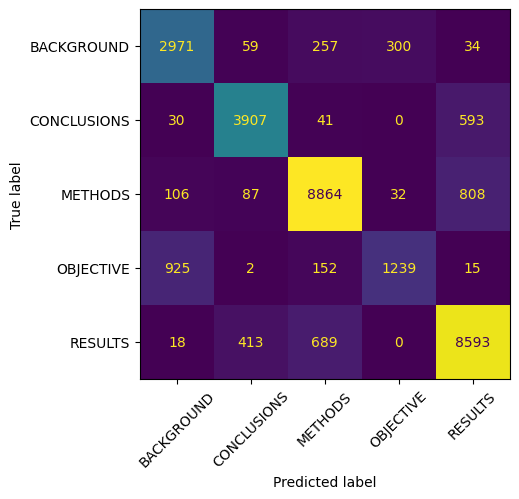

In [67]:
labels = test_df.category.cat.categories.to_numpy()
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(
    labels_test, model_preds_test, display_labels=labels, xticks_rotation=45,
    ax=ax, colorbar=False);

### Find the most wrong

In [68]:
test_pred_classes = [labels[i] for i in model_preds_test]

In [69]:
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(model_pred_probs_test, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["category"] # create binary column for whether the prediction is right or not
test_df.head()

,id,category,text,number_of_string,total_lines,prediction,pred_prob,correct
0,24845963,BACKGROUND,This study analyzed liver function abnormaliti...,1,9,OBJECTIVE,0.491376,False
1,24845963,RESULTS,A post hoc analysis was conducted with the use...,2,9,METHODS,0.387264,False
2,24845963,RESULTS,Liver function tests ( LFTs ) were measured at...,3,9,METHODS,0.787367,False
3,24845963,RESULTS,Survival analyses were used to assess the asso...,4,9,METHODS,0.800279,False
4,24845963,RESULTS,The percentage of patients with abnormal LFTs ...,5,9,RESULTS,0.866840,True


In [70]:
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]

In [71]:
top_100_wrong.head()

,id,category,text,number_of_string,total_lines,prediction,pred_prob,correct
22677,25421390,METHODS,Traces with biphasic ST-events of the FECG ( i...,6,11,RESULTS,0.963895,False
29532,25057155,CONCLUSIONS,The highest concentrations of non-transferrin-...,8,9,RESULTS,0.957105,False
7870,24984529,METHODS,"A total of @,@ participants had three valid sy...",6,13,RESULTS,0.955054,False
10623,24338461,METHODS,At one month there was significant improvement...,7,13,RESULTS,0.954900,False
19223,24786163,METHODS,"Of the @ dogs receiving placebo , @ ( @ % ) vo...",8,11,RESULTS,0.953420,False


In [72]:
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _, _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: METHODS, Pred: RESULTS, Prob: 0.9638954997062683, Line number: 6, Total lines: 11

Text:
Traces with biphasic ST-events of the FECG ( index ) were compared with traces without biphasic events of the FECG .

-----

Target: CONCLUSIONS, Pred: RESULTS, Prob: 0.9571049809455872, Line number: 8, Total lines: 9

Text:
The highest concentrations of non-transferrin-bound iron resulted from the administration of supplemental doses of iron without food .

-----

Target: METHODS, Pred: RESULTS, Prob: 0.9550538063049316, Line number: 6, Total lines: 13

Text:
A total of @,@ participants had three valid systolic readings , and @,@ had three valid diastolic readings .

-----

Target: METHODS, Pred: RESULTS, Prob: 0.9548995494842529, Line number: 7, Total lines: 13

Text:
At one month there was significant improvement of the scores for all the examined cases .

-----

Target: METHODS, Pred: RESULTS, Prob: 0.9534202218055725, Line number: 8, Total lines: 11

Text:
Of the @ dogs receiving place

## Make example prediction

In [73]:
raw_text = '''Previous studies using viral cultures rarely reported herpes simplex virus type 2 (HSV-2)
isolation from the mouth. We sought to characterize oral HSV-2 shedding as detected by HSV DNA polymerase 
chain reaction among HSV-2-seropositive men. Participants collected daily swabs from oral and anogenital 
areas for HSV detection with a quantitative polymerase chain reaction assay. A total of 109 HSV-2-seropositive 
men (59 of whom were human immunodeficiency virus [HIV] negative, and 50 of whom were HIV positive) were 
sampled for a median of 64 consecutive days. Forty-four (40.4%) had HSV-2 detected from oral swabs on at 
least 1 day. Oral HSV-2 was detected on 148 (2.3%) of 6,422 days, genital HSV-2 was detected on 1,110 (17%) 
of 6,505 days, oral HSV-1 was detected on 220 (5.5%) of 4,018 days, and genital HSV-1 was detected on 88 (2.2%) 
of 4,073 days. Oral HSV-2 shedding was never associated with an oral lesion, but it was often concurrent with 
genital HSV-2 shedding. Both oral and genital HSV-2 were detected on 90 (61%) of 148 days with oral HSV-2 shedding. 
Oral HSV-2 shedding occurred on 90 (8.2%) of 1,110 days with genital HSV-2 shedding, versus 58 (1.1%) of 5,316 days 
without genital HSV-2 shedding (P<.001). The HIV-positive men shed HSV-2 orally more frequently than did the 
HIV-negative men (odds ratio, 2.7 [95% confidence interval, 1.1-7.1]). Oral HSV-2 reactivation was common 
(especially among HIV-positive men), was always asymptomatic, and often occurred on days of genital HSV-2 
reactivation.
'''

**Background**: Previous studies using viral cultures rarely reported herpes simplex virus type 2 (HSV-2) isolation from the mouth. We sought to characterize oral HSV-2 shedding as detected by HSV DNA polymerase chain reaction among HSV-2-seropositive men.

**Methods**: Participants collected daily swabs from oral and anogenital areas for HSV detection with a quantitative polymerase chain reaction assay.

**Results**: A total of 109 HSV-2-seropositive men (59 of whom were human immunodeficiency virus [HIV] negative, and 50 of whom were HIV positive) were sampled for a median of 64 consecutive days. Forty-four (40.4%) had HSV-2 detected from oral swabs on at least 1 day. Oral HSV-2 was detected on 148 (2.3%) of 6,422 days, genital HSV-2 was detected on 1,110 (17%) of 6,505 days, oral HSV-1 was detected on 220 (5.5%) of 4,018 days, and genital HSV-1 was detected on 88 (2.2%) of 4,073 days. Oral HSV-2 shedding was never associated with an oral lesion, but it was often concurrent with genital HSV-2 shedding. Both oral and genital HSV-2 were detected on 90 (61%) of 148 days with oral HSV-2 shedding. Oral HSV-2 shedding occurred on 90 (8.2%) of 1,110 days with genital HSV-2 shedding, versus 58 (1.1%) of 5,316 days without genital HSV-2 shedding (P<.001). The HIV-positive men shed HSV-2 orally more frequently than did the HIV-negative men (odds ratio, 2.7 [95% confidence interval, 1.1-7.1]).

**Conclusions**: Oral HSV-2 reactivation was common (especially among HIV-positive men), was always asymptomatic, and often occurred on days of genital HSV-2 reactivation.

### Preprocesing text

#### Clean text

In [74]:
import re
raw_sentence_sub = re.sub(r'\.*\d', '@', raw_text)
splitted_sentence = raw_sentence_sub.split('.')
sentences = [(re.sub('[^A-Za-z@]+', ' ', line)).strip() for line in splitted_sentence if not line=='\n']

In [75]:
sentences[:5]

['Previous studies using viral cultures rarely reported herpes simplex virus type @ HSV @ isolation from the mouth',
 'We sought to characterize oral HSV @ shedding as detected by HSV DNA polymerase chain reaction among HSV @ seropositive men',
 'Participants collected daily swabs from oral and anogenital areas for HSV detection with a quantitative polymerase chain reaction assay',
 'A total of @@@ HSV @ seropositive men @@ of whom were human immunodeficiency virus HIV negative and @@ of whom were HIV positive were sampled for a median of @@ consecutive days',
 'Forty four @@@ had HSV @ detected from oral swabs on at least @ day']

#### Creating dict with text and needed information (line_number and total_lines)

In [76]:
list_of_sentences_dicts = []
for number, line in enumerate(sentences):
    dict_of_sentence = dict()
    dict_of_sentence['text'] = line
    dict_of_sentence['line_number'] = number + 1
    dict_of_sentence['total_lines'] = len(sentences)
    
    list_of_sentences_dicts.append(dict_of_sentence)

In [77]:
list_of_sentences_dicts[0:5]

[{'text': 'Previous studies using viral cultures rarely reported herpes simplex virus type @ HSV @ isolation from the mouth',
  'line_number': 1,
  'total_lines': 11},
 {'text': 'We sought to characterize oral HSV @ shedding as detected by HSV DNA polymerase chain reaction among HSV @ seropositive men',
  'line_number': 2,
  'total_lines': 11},
 {'text': 'Participants collected daily swabs from oral and anogenital areas for HSV detection with a quantitative polymerase chain reaction assay',
  'line_number': 3,
  'total_lines': 11},
 {'text': 'A total of @@@ HSV @ seropositive men @@ of whom were human immunodeficiency virus HIV negative and @@ of whom were HIV positive were sampled for a median of @@ consecutive days',
  'line_number': 4,
  'total_lines': 11},
 {'text': 'Forty four @@@ had HSV @ detected from oral swabs on at least @ day',
  'line_number': 5,
  'total_lines': 11}]

#### Reformatting arrays from list of dict

In [78]:
sentence_line_numbers = [dict_of_sentence['line_number'] for dict_of_sentence in list_of_sentences_dicts]
# One-hot encode
sentence_line_numbers_one_hot = tf.one_hot(sentence_line_numbers, depth=number_of_strings_counts_95_perc)
sentence_line_numbers_one_hot

<tf.Tensor: shape=(11, 14), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]],
      dtype=float32)>

In [79]:
sentence_total_numbers = [dict_of_sentence['total_lines'] for dict_of_sentence in list_of_sentences_dicts]
# One-hot encode
sentence_total_numbers_one_hot = tf.one_hot(sentence_line_numbers, depth=number_of_total_lines_counts_95_perc)
sentence_total_numbers_one_hot

<tf.Tensor: shape=(11, 19), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 

In [80]:
sentences_chars = [split_chars(sentence) for sentence in sentences]
sentences_chars[0:5]

['P r e v i o u s   s t u d i e s   u s i n g   v i r a l   c u l t u r e s   r a r e l y   r e p o r t e d   h e r p e s   s i m p l e x   v i r u s   t y p e   @   H S V   @   i s o l a t i o n   f r o m   t h e   m o u t h',
 'W e   s o u g h t   t o   c h a r a c t e r i z e   o r a l   H S V   @   s h e d d i n g   a s   d e t e c t e d   b y   H S V   D N A   p o l y m e r a s e   c h a i n   r e a c t i o n   a m o n g   H S V   @   s e r o p o s i t i v e   m e n',
 'P a r t i c i p a n t s   c o l l e c t e d   d a i l y   s w a b s   f r o m   o r a l   a n d   a n o g e n i t a l   a r e a s   f o r   H S V   d e t e c t i o n   w i t h   a   q u a n t i t a t i v e   p o l y m e r a s e   c h a i n   r e a c t i o n   a s s a y',
 'A   t o t a l   o f   @ @ @   H S V   @   s e r o p o s i t i v e   m e n   @ @   o f   w h o m   w e r e   h u m a n   i m m u n o d e f i c i e n c y   v i r u s   H I V   n e g a t i v e   a n d   @ @   o f   w h o m   w e r e   H I V   p o s 

### Make prediction

In [81]:
with tf.device('/cpu:0'):
    my_pred_probs = loaded_model.predict(x=(sentence_line_numbers_one_hot,
                                            sentence_total_numbers_one_hot,
                                            tf.constant(sentences),
                                            tf.constant(sentences_chars)))
my_pred_probs

1/1 [==============================] - 2s 2s/step


array([[0.8289187 , 0.01925033, 0.02270481, 0.11785804, 0.01126817],
       [0.49319994, 0.01662897, 0.02747716, 0.42362973, 0.03906425],
       [0.06563613, 0.0067664 , 0.8376378 , 0.06581171, 0.02414794],
       [0.00950063, 0.08470093, 0.06938505, 0.01772238, 0.818691  ],
       [0.00747486, 0.09771249, 0.16874929, 0.01527441, 0.7107889 ],
       [0.00798286, 0.1452821 , 0.34426442, 0.01425648, 0.4882141 ],
       [0.03208856, 0.15127532, 0.02250418, 0.02913842, 0.7649935 ],
       [0.00482701, 0.02958829, 0.01793129, 0.01063083, 0.9370225 ],
       [0.01003982, 0.1450603 , 0.02691941, 0.0167592 , 0.80122125],
       [0.01655422, 0.10225944, 0.00581039, 0.02576599, 0.84961   ],
       [0.0341993 , 0.21716931, 0.00942542, 0.01548179, 0.7237242 ]],
      dtype=float32)

### Reformatting prediction

In [82]:
my_preds = tf.argmax(my_pred_probs, axis=1)
my_preds

<tf.Tensor: shape=(11,), dtype=int64, numpy=array([0, 0, 2, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int64)>

In [83]:
my_labels_pred = [labels[i] for i in my_preds]
my_labels_pred

['BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS']

### Evaluating prediction

In [84]:
right_labels_pred = ['BACKGROUND','BACKGROUND', 'METHODS', 'RESULTS', 'RESULTS', 
                'RESULTS', 'RESULTS','RESULTS', 'RESULTS', 'RESULTS', 
                'CONCLUSIONS']

right_labels = [list(labels).index(i) for i in right_labels_pred]
right_labels

[0, 0, 2, 4, 4, 4, 4, 4, 4, 4, 1]

In [85]:
df_pred = pd.DataFrame({'predicted_labels':my_labels_pred, 'right_labels':right_labels_pred})
df_pred

,predicted_labels,right_labels
0,BACKGROUND,BACKGROUND
1,BACKGROUND,BACKGROUND
2,METHODS,METHODS
3,RESULTS,RESULTS
4,RESULTS,RESULTS
5,RESULTS,RESULTS
6,RESULTS,RESULTS
7,RESULTS,RESULTS
8,RESULTS,RESULTS
9,RESULTS,RESULTS


In [86]:
print(f'Accuracy score is {round(accuracy_score(right_labels, my_preds), 3)}')
print(f'Precision score is {round(precision_score(right_labels, my_preds, average="weighted", zero_division=0), 3)}')
print(f'Recall score is {round(recall_score(right_labels, my_preds, average="weighted"), 3)}')
print(f'F1-score is {round(f1_score(right_labels, my_preds, average="weighted"), 3)}')

Accuracy score is 0.909
Precision score is 0.83
Recall score is 0.909
F1-score is 0.867


### Building text with labels

In [87]:
from nltk import tokenize

In [88]:
raw_sentences = tokenize.sent_tokenize(raw_text)
raw_sentences = [line.replace('\n', '') for line in raw_sentences]
raw_sentences

['Previous studies using viral cultures rarely reported herpes simplex virus type 2 (HSV-2)isolation from the mouth.',
 'We sought to characterize oral HSV-2 shedding as detected by HSV DNA polymerase chain reaction among HSV-2-seropositive men.',
 'Participants collected daily swabs from oral and anogenital areas for HSV detection with a quantitative polymerase chain reaction assay.',
 'A total of 109 HSV-2-seropositive men (59 of whom were human immunodeficiency virus [HIV] negative, and 50 of whom were HIV positive) were sampled for a median of 64 consecutive days.',
 'Forty-four (40.4%) had HSV-2 detected from oral swabs on at least 1 day.',
 'Oral HSV-2 was detected on 148 (2.3%) of 6,422 days, genital HSV-2 was detected on 1,110 (17%) of 6,505 days, oral HSV-1 was detected on 220 (5.5%) of 4,018 days, and genital HSV-1 was detected on 88 (2.2%) of 4,073 days.',
 'Oral HSV-2 shedding was never associated with an oral lesion, but it was often concurrent with genital HSV-2 shedding.

In [89]:
my_labels_pred

['BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS']

In [90]:
final_dict = dict()
for label, line in zip(my_labels_pred,raw_sentences):
    final_dict.setdefault(label, []).append(line)

In [91]:
final_dict

{'BACKGROUND': ['Previous studies using viral cultures rarely reported herpes simplex virus type 2 (HSV-2)isolation from the mouth.',
  'We sought to characterize oral HSV-2 shedding as detected by HSV DNA polymerase chain reaction among HSV-2-seropositive men.'],
 'METHODS': ['Participants collected daily swabs from oral and anogenital areas for HSV detection with a quantitative polymerase chain reaction assay.'],
 'RESULTS': ['A total of 109 HSV-2-seropositive men (59 of whom were human immunodeficiency virus [HIV] negative, and 50 of whom were HIV positive) were sampled for a median of 64 consecutive days.',
  'Forty-four (40.4%) had HSV-2 detected from oral swabs on at least 1 day.',
  'Oral HSV-2 was detected on 148 (2.3%) of 6,422 days, genital HSV-2 was detected on 1,110 (17%) of 6,505 days, oral HSV-1 was detected on 220 (5.5%) of 4,018 days, and genital HSV-1 was detected on 88 (2.2%) of 4,073 days.',
  'Oral HSV-2 shedding was never associated with an oral lesion, but it was 

In [92]:
for key, value in final_dict.items():
    text = ' '.join(value)
    print(f'\033[1m{key}\033[0m: {text}')

BACKGROUND: Previous studies using viral cultures rarely reported herpes simplex virus type 2 (HSV-2)isolation from the mouth. We sought to characterize oral HSV-2 shedding as detected by HSV DNA polymerase chain reaction among HSV-2-seropositive men.
METHODS: Participants collected daily swabs from oral and anogenital areas for HSV detection with a quantitative polymerase chain reaction assay.
RESULTS: A total of 109 HSV-2-seropositive men (59 of whom were human immunodeficiency virus [HIV] negative, and 50 of whom were HIV positive) were sampled for a median of 64 consecutive days. Forty-four (40.4%) had HSV-2 detected from oral swabs on at least 1 day. Oral HSV-2 was detected on 148 (2.3%) of 6,422 days, genital HSV-2 was detected on 1,110 (17%) of 6,505 days, oral HSV-1 was detected on 220 (5.5%) of 4,018 days, and genital HSV-1 was detected on 88 (2.2%) of 4,073 days. Oral HSV-2 shedding was never associated with an oral lesion, but it was often concurrent with genital HSV-2 shedd